In [83]:
import pandas as pd
import numpy as np
import re
import pickle
import seaborn as sb

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
import nltk

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score
from sklearn.preprocessing import LabelEncoder

import xgboost
import optuna

import matplotlib.pyplot as plt
from wordcloud import WordCloud

In [84]:
nltk.download('punkt_tab');
nltk.download('averaged_perceptron_tagger_eng');
nltk.download('wordnet');

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\marva\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\marva\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\marva\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Klasifikacija vina na osnovu senzotnih opisa

U prethodnom poglavlju pokazali smo kako se vino može klasifikovati na crno i belo na osnovu fizičko-hemijskih karakteristika. 

Kako je u realnosti malo verovatno da su nam poznati ti podaci, ali ne i da li je vino crno ili belo, posmatramo malo drugačiji problem: klasifikacija stila vina na osnovu senzornih opisa.

**Senzorni opis** podrazumeva miris, ukus, teksturu, pitkost i slične opise koje možemo pronaći u recenzijama vina.

Kako nisu sva crna ni sva bela vina ista, potrebna nam je sitnija podela na **stilove vina**:

- *Champagne & Sparkling Wines* 
- *Light-Bodied White Wines*    
- *Aromatic White Wines*
- *Full-Bodied White Wines*
- *Rosé Wines*
- *Light-Bodied Red Wines*
- *Medium-Bodied Red Wines*
- *Full-Bodied Red Wines*
- *Dessert & Fortified Wines*
 
Više o pojedinačnim stilovima vina na https://winefolly.com/tips/the-9-major-wine-styles/.

Za potrebe ovog projekta koristili smo skup podataka sa recenzijama vina dostupan na https://www.kaggle.com/datasets/zynicide/wine-reviews. Sastoji se iz 130.000 recenzija i informacija o vinu i recenzentu i u svom izvornom obliku ne sadrži stil vina kao kolonu.

Projekat se sastoji iz tri dela:

1. Analiza skupa podataka - određivanje stila vina na osnovu imena i vrste grožđa
2. Priprema teksta - izdvajanje ključnih reči iz teksta recenzije i vektorizacija 
3. Klasifikacija - traženje optimalnog modela i ocena greške 

## Analiza skupa podataka

U izlazu sledeće ćelije možemo videti strukturu našeg skupa podataka. Kolone koje će nama biti od značaja su:
- `description` - tekst recenzije, do 135 reči 
- `title` - naziv vina
- `variety` -  vrsta grožđa od kojeg je vino napravljeno, 707 različih vrednosti

In [85]:
df = pd.read_csv("winemag-data-130k-v2.csv")
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


In [86]:
len(df['title'].unique())

118840

medijalna dužina: 39.0, opseg: [3, 135]


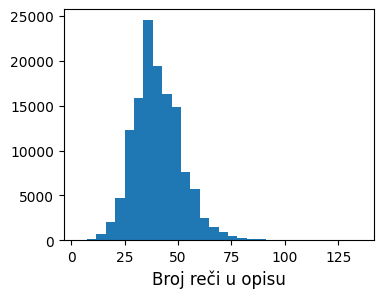

In [87]:
word_counts = [len(text.split()) for text in df['description']]
print(f"medijalna dužina: {np.median(word_counts)}, opseg: [{np.min(word_counts)}, {np.max(word_counts)}]")

plt.figure(figsize=(4, 3))
plt.hist(word_counts, bins=30)
plt.xlabel('Broj reči u opisu', fontsize=12)
plt.show()

In [88]:
df['variety'].value_counts()

variety
Pinot Noir                    13272
Chardonnay                    11753
Cabernet Sauvignon             9472
Red Blend                      8946
Bordeaux-style Red Blend       6915
                              ...  
Cabernet Sauvignon-Barbera        1
Sauvignonasse                     1
Forcallà                          1
Meseguera                         1
Bobal-Cabernet Sauvignon          1
Name: count, Length: 707, dtype: int64

### Određivanje stila

Kako u skupu postoji 707 vrsti grozda, želimo da ih grupišemo u 9 pomenutih kategorija.

Umesto domenskog znanja, za to je korišćen gpt-4o-mini i rezultati su upisani u `wine_variety_style.csv`. 
Za vina koja su obeležena kao mešavina vrsta ("Red Blend", "White Blend") nije bilo moguće odrediti tačnu kategoriju na ovaj nacin, zbog čega je za njih na isti način tražena kategorija direktno po imenu, i upisana u `wine_title_style.csv`. Za upite korišćena je skripta `get_wine_styles.py`

Bilo je potrebno ispitati 707 vrsti grozda i 10k pojedinačnih vina, čime smo dobili informafcije o kategoriji za svih 130k vina.

Iako nemamo način da utvrdimo tačnost ovakve klasifikacije, na primeru vina iz Srbije vidimo da deluje korektno. Model se oslanja na podatke sa interneta koji sami za sebe već nisu uvek tačni što je šum na koji ne možemo da utičemo (https://www.vivino.com/US/en/budimir-svb-rosa/w/1970828).

In [89]:
wine_variety_style = pd.read_csv('wine_variety_style.csv')
wine_title_style = pd.read_csv('wine_title_style.csv')
print(wine_variety_style['style'].value_counts())

style
Full-Bodied Red Wines          187
Light-Bodied White Wines       163
Aromatic White Wines           152
Medium-Bodied Red Wines        105
Light-Bodied Red Wines          45
Full-Bodied White Wines         24
Dessert & Fortified Wines       17
Champagne & Sparkling Wines      5
Rosé Wines                       4
Name: count, dtype: int64


In [90]:
df['title'] = (df['title'].str.replace('  ', ' ', regex=False).str.replace(r'\s\(.*(\(.*\))?\)', '', regex=True).str.strip())  
df_merged = pd.merge(df, wine_variety_style, how='left', left_on='variety', right_on='variety')
df_merged = pd.merge(df_merged, wine_title_style, how='left', left_on='title', right_on='wine_name')
df_merged['style'] = df_merged['style_x'].fillna(df_merged['style_y'])
# df_merged.info()

In [91]:
df_merged[df_merged['country'] == 'Serbia'][['title','variety','style']]

,title,variety,style
5090,Milijan Jelić 2011 Morava,Morava,Light-Bodied White Wines
22421,Agrina 2012 Portuguiser Blauer Portugieser,Blauer Portugieser,Light-Bodied Red Wines
29311,Budimir 2009 Sub Rosa Red,Red Blend,Medium-Bodied Red Wines
38555,Budimir 2009 Margus Margi Riesling,Riesling,Aromatic White Wines
38961,Budimir 2013 Župska Tamjanika,Tamjanika,Aromatic White Wines
51832,Agrina 2014 Portuguiser,Portuguiser,Light-Bodied Red Wines
64406,Budimir 2009 Sub Rosa Red,Red Blend,Medium-Bodied Red Wines
70991,Budimir 2007 Svb Rosa Red,Red Blend,Rosé Wines
72905,Budimir 2008 Margus Margi Riesling,Riesling,Aromatic White Wines
108175,Agrina 2014 Portuguiser,Portuguiser,Light-Bodied Red Wines


In [92]:
df = df_merged[['description','title','style']].dropna(subset=['style'])
# df.info()

In [93]:
df['style'].value_counts()

style
Full-Bodied Red Wines          47883
Aromatic White Wines           17556
Medium-Bodied Red Wines        15920
Light-Bodied Red Wines         14971
Full-Bodied White Wines        14572
Light-Bodied White Wines        9630
Champagne & Sparkling Wines     4604
Rosé Wines                      3785
Dessert & Fortified Wines       1098
Name: count, dtype: int64

### Izdvajanje ključnih reči recenzije

Recenzije vina su kratke i detaljne i opisuju njegov subjektivni osećaj. Konstrukcije rečenica su jednostavne i ne zavise mnogo od redosleda reči, što nam govori da je dovoljno da posmatramo samo pojedinačne reči koje se u komentaru nalaze. 

Na primeru vidimo opis koji sadrži reči "ripe", "smooth", "tannin", "berry", koje mogu da nas asociraju na jako crno vino, a teško bi se našle u opisu penušavog vina.

U opisu su ključne imenice, pridevi i glagoli, zbog čega ćemo ukloniti sve ostale vrste reči.

Na ovaj način su obrađene sve recenzije iz skupa, i sačuvane u `x_clean.pkl` radi lakšeg pokretanja.

In [94]:
X = df['description']  
y = df['style']
print(X[1])
print(y[1])

This is ripe and fruity, a wine that is smooth while still structured. Firm tannins are filled out with juicy red berry fruits and freshened with acidity. It's  already drinkable, although it will certainly be better from 2016.
Full-Bodied Red Wines


In [95]:
stop_words = stopwords.words('english')
lemmatizer = WordNetLemmatizer() 

def clean_text(text):
    text = text.lower()
    text = ''.join(char if char.isalpha() else ' ' for char in text)
    
    pos_tagged = pos_tag(text.split())
    text = [word for word, tag in pos_tagged if tag[0] in {'J', 'N', 'V'} and word not in stop_words]
    
    text = [lemmatizer.lemmatize(word) for word in text]
    
    return " ".join(text)

In [96]:
clean_text(X[1])

'ripe fruity wine smooth structured firm tannin filled juicy red berry fruit freshened acidity drinkable better'

In [97]:
# X = X.apply(clean_text)
# with open("x_clean.pkl", "wb") as file:
#     pickle.dump(X, file)
with open("x_clean.pkl", "rb") as file:
    X = pickle.load(file)

In [98]:
X.head()

0    aroma include tropical fruit broom brimstone d...
1    ripe fruity wine smooth structured firm tannin...
2    tart snappy flavor lime flesh rind dominate gr...
3    pineapple rind lemon pith orange blossom start...
4    much regular bottling come rough tannic rustic...
Name: description, dtype: object

### Podela i vektorizacija

Za izdvajanje kljičnih reči nismo primenili nikakvo specifično znanje koje bi bilo vezano za skup podataka. Sada je potrebno izdvojiti skup za testiranje kako bismo imali primere koji nisu uticali na dalji proces.

Na početku ćemo podeliti podatke samo na skup za obučavanje i testiranje, dok ćemo skup za validaciju izdvojiti kasnije iz skupa za obučavanje i koristiti ga za evaluaciju modela.

Za vektorizaciju teksta koristimo **TF-IDF** (*Term Frequency - Inverse Document Frequency*) : 
$$
TF\text{-}IDF = TF \cdot IDF
$$
$$
TF = \frac{\text{Broj pojavljivanja reči u dokumentu}}{\text{Ukupan broj reči u dokumentu}}
$$

$$
IDF = \log\left(\frac{\text{Ukupan broj dokumenata}}{\text{Broj dokumenata koji sadrže tu reč}}\right)
$$

**IDF** je tu da smanji težinu reči koje se pojavljuju u mnogim tekstovima, i samim tim nose malo informacije. 

Kako su se komentari sastoje od malo, ali pažljivo izabranih, reči, one se često neće ponavljati unutar jednog teksta, i samim tim će sve imati isti **TF**. To nam je ok.

Iako smo rekli da nas zanimaju reči koje se retko pojavljuju, i za to postoji granica. Reči koje se pojavljuju u tek ponekom primeru mogu dati lažnu sliku svog značenja (u našem primeru reč `lion` se pojavljuje samo jednom u odudarajućem komentaru 'Imported by Lion Nathan USA.' i nema nikakve veze sa tim što je vino stila Aromatic White Wines), dok sa druge strane nepotrebnu povećavaju dimenziju. Iz tih razloga, fokusnirani smo samo na reči koje se pojavljuju u barem 100 dokumenata (~0.1%)

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [100]:
tfidf_vectorizer = TfidfVectorizer(min_df=100) 

tfidf_train_vectors = tfidf_vectorizer.fit_transform(X_train)
tfidf_test_vectors = tfidf_vectorizer.transform(X_test)

print(len(tfidf_vectorizer.get_feature_names_out()))
print(tfidf_vectorizer.get_feature_names_out())

2045
['ability' 'abound' 'abrasive' ... 'zing' 'zingy' 'zippy']


## Klasifikacija

Poredimo dva pristupa:
- Naivni Bajesov klasifikator
- Nasumične šume (sa i bez gradijentnog pojačivanja)

Kako bismo mogli da izaberemo optimalan model, potrebno da iz skupa podataka za obučavanje izdvojimo skup za validaciju. Klase nisu jednako reprezentovane, ali nam je to u redu jer ni u stavrnosti nisu jednako verovatne.

Diskutabilno je koje je najbolja metrika za poređenje ovih modela, jer to zavisi od toga da li nam je bitnija opšta tačnost modela ili da svaku klasu što bolje razlikuje od ostalih. Iz tog razloga ćemo za svaki model posmatrati više metrika i matricu konfuzije, što ispisujemo funkcijom `print_report`.

Takođe se postavlja pitanje da li su nam sve greške jednako problematične - da li je isto ako model zameni jako crno vino za srednje jako, ili za penušavo. Iz tog razloga dodatno ispisujemo statistike grupisanih klasa funkcijom `print_grouped_report`. Ovde se posmatra odnos crnih, belih i rozé vina, dok se desertna zanemaruju. Desertna vina su posebno problematična jer pored toga što ih ima malo (~8%), imaju veći diverzitet. Mogu biti crna, bela, jača i slabija, što ih čini znatno težim za izolovanje. 

In [120]:
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(tfidf_train_vectors, y_train, test_size=0.2, random_state=42,stratify=y_train)

In [102]:
def print_report(true_values, pred_values, model):
    
    wine_style_order = [
    "Champagne & Sparkling Wines","Light-Bodied White Wines", "Aromatic White Wines", "Full-Bodied White Wines", 
    "Rosé Wines", "Light-Bodied Red Wines", "Medium-Bodied Red Wines", "Full-Bodied Red Wines", "Dessert & Fortified Wines"
    ]
    
    class_report = classification_report(true_values, pred_values, labels=wine_style_order)
    print(f"Classification report for {model}:\n\n", class_report)
    
    conf_matrix = confusion_matrix(true_values, pred_values, labels=wine_style_order)

    plt.figure(figsize=(5, 4))
    sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=wine_style_order, yticklabels=wine_style_order)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(f'Confusion matrix for {model}')
    plt.xticks(rotation=90)  
    plt.show()

In [103]:
def print_grouped_report(true_values, pred_values, model):
    grouped_wine_styles = {
        "white" : ["Champagne & Sparkling Wines","Light-Bodied White Wines", "Aromatic White Wines", "Full-Bodied White Wines"], 
        "red"   : ["Light-Bodied Red Wines", "Medium-Bodied Red Wines", "Full-Bodied Red Wines"],
        "rosé"  : ["Rosé Wines"],
        "desert": ["Dessert & Fortified Wines"]
    }

    inverted_wine_styles = {wine: group for group, wines in grouped_wine_styles.items() for wine in wines}

    y_train_val_grouped = [inverted_wine_styles[style] for style in true_values]
    y_pred_grouped = [inverted_wine_styles[style] for style in pred_values]

    grouped_order = list(grouped_wine_styles.keys())[:3]

    class_report = classification_report(y_train_val_grouped, y_pred_grouped)
    print(f"Grouped classification report for {model}:\n\n", class_report)

    conf_matrix = confusion_matrix(y_train_val_grouped, y_pred_grouped, labels=grouped_order)

    plt.figure(figsize=(6, 5))
    sb.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=grouped_order, yticklabels=grouped_order)
    plt.title(f'Grouped confusion matrix for {model}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

### Naivni Bajesov klasifikator
Multinomijalni naivni bajesov klasifikator podrazumeva da atribut koji modelujemo ima multinomijalnu raspodelu. 

Iz Bajesove formule koja se koristi za ovaj model,  $P(S_k | r) = \frac{P(S_k) \cdot P(r | S_k)}{P(r)}$, vidimo da će vino sa recenzijom $r$ koje ima jednake verovatnoće $P(r | S_i)$ i $P(r | S_j)$ za dva različita stila $i$ i $j$ biti izabran onaj stil koji je inače više prisutan. 

Ovim se delimično može objasniti zašto su sve vrste vina češće zamenjene za jaka crna, nego za lagana, što vidimo u matrici konfuzije.

Iz matrica konfuzije, kao i grupne tačnosti, takođe možemo videti da model bolje predviđa da li je vino crno ili belo, nego koja je tačno vrsta belog ili crnog vina u pitanju.

In [104]:
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_train, y_train_train)
y_pred = nb_classifier.predict(X_train_val)

Classification report for Naive Bayes:

                              precision    recall  f1-score   support

Champagne & Sparkling Wines       0.78      0.48      0.59       736
   Light-Bodied White Wines       0.62      0.42      0.50      1541
       Aromatic White Wines       0.62      0.78      0.69      2809
    Full-Bodied White Wines       0.70      0.69      0.69      2332
                 Rosé Wines       0.76      0.47      0.58       606
     Light-Bodied Red Wines       0.83      0.47      0.60      2395
    Medium-Bodied Red Wines       0.54      0.20      0.29      2547
      Full-Bodied Red Wines       0.66      0.94      0.78      7661
  Dessert & Fortified Wines       0.92      0.07      0.13       176

                   accuracy                           0.67     20803
                  macro avg       0.71      0.50      0.54     20803
               weighted avg       0.67      0.67      0.64     20803



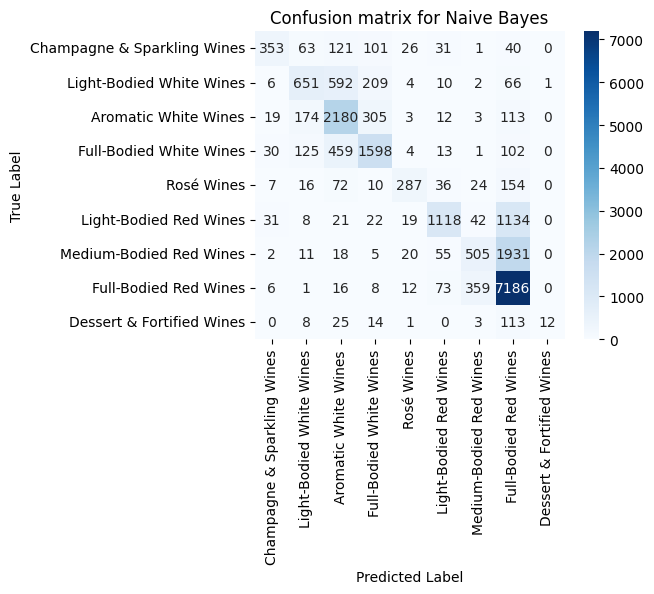

In [105]:
print_report(y_train_val, y_pred, "Naive Bayes")

Grouped classification report for Naive Bayes:

               precision    recall  f1-score   support

      desert       0.92      0.07      0.13       176
         red       0.94      0.98      0.96     12603
        rosé       0.76      0.47      0.58       606
       white       0.96      0.94      0.95      7418

    accuracy                           0.95     20803
   macro avg       0.90      0.62      0.66     20803
weighted avg       0.94      0.95      0.94     20803



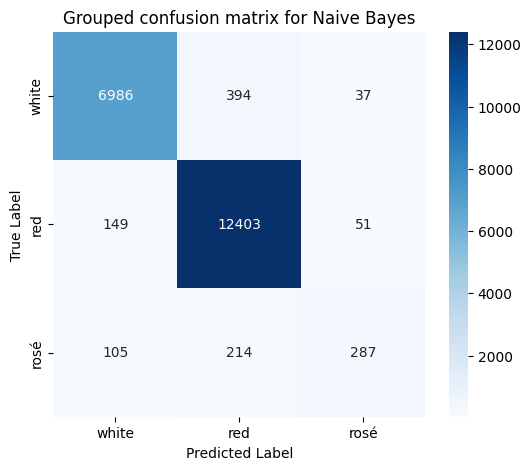

In [106]:
print_grouped_report(y_train_val,y_pred,"Naive Bayes")

#### Interpretacija modela
Iako naivni Bajesov klasifikator ima često slabije performanse od sofisticiranijih metoda, njegova velika prednost je interpretabilnost. Za svaki od stilova vina možemo saznati reči koje su za nju najrelevantnije:

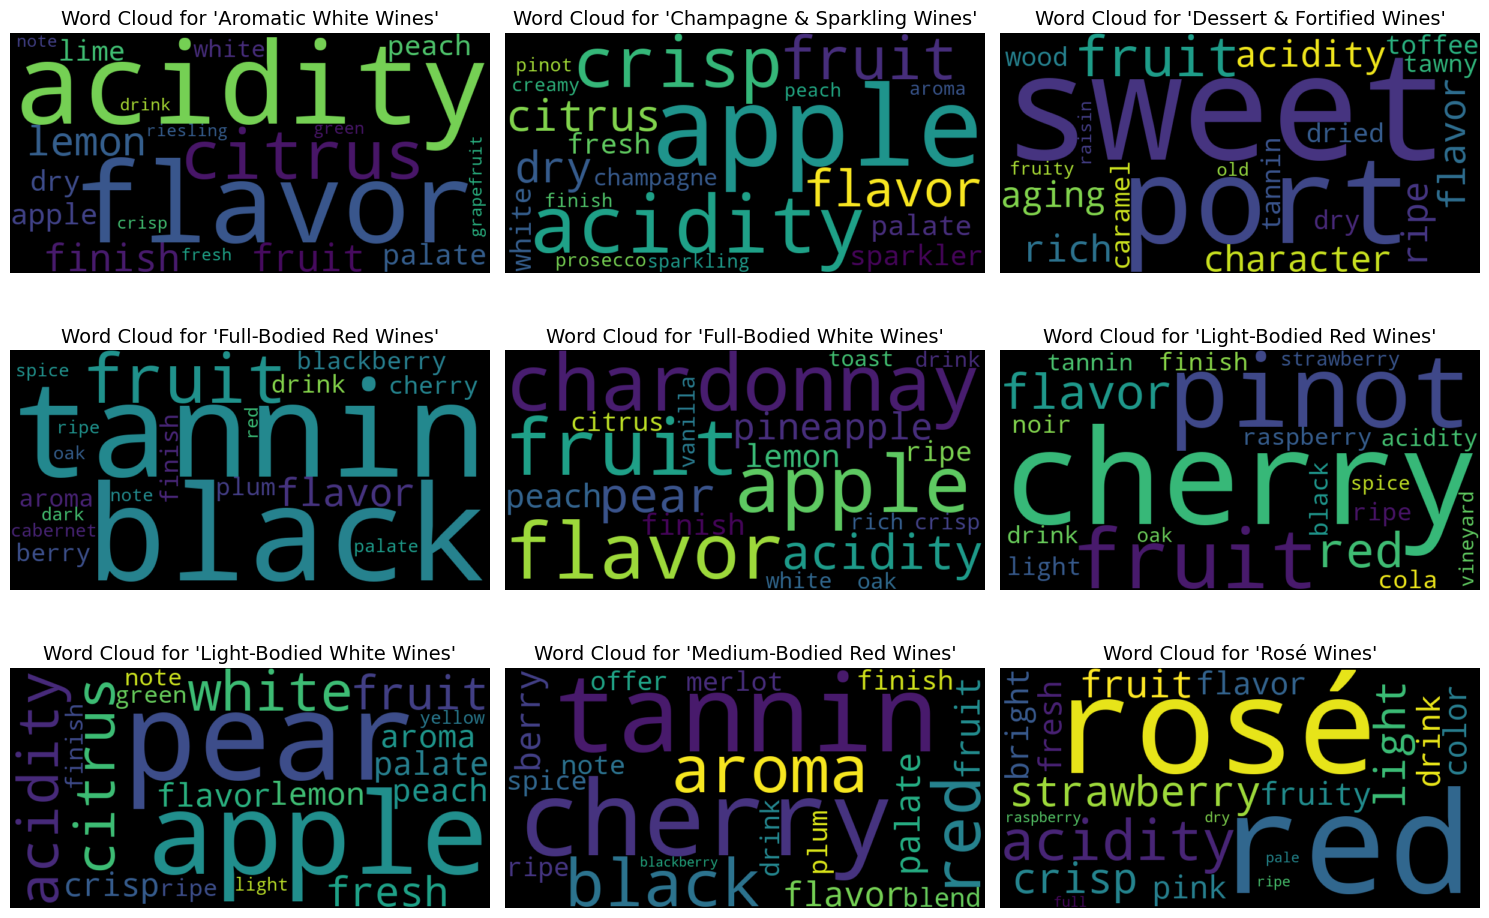

In [107]:
feature_names = tfidf_vectorizer.get_feature_names_out()
log_probabilities = nb_classifier.feature_log_prob_
log_prob_df = pd.DataFrame(log_probabilities, columns=feature_names, index=nb_classifier.classes_)

def generate_word_cloud(category, log_prob_df, num_words=20):
    top_words = log_prob_df.loc[category].sort_values(ascending=False).head(num_words)
    word_freq = {word: value for word, value in top_words.items() if word != 'wine'}
    wordcloud = WordCloud(width=800, height=400).generate_from_frequencies(word_freq)
    return wordcloud


fig, axs = plt.subplots(3, 3, figsize=(15, 10))
axs = axs.flatten()

for i, category in enumerate(nb_classifier.classes_):
    wordcloud = generate_word_cloud(category, log_prob_df)
    axs[i].imshow(wordcloud, interpolation='bilinear')
    axs[i].axis('off')
    axs[i].set_title(f"Word Cloud for '{category}'", fontsize=14)

for j in range(i + 1, 9):
    axs[j].axis('off')

plt.tight_layout()
plt.show()

## Nasumična šuma

Drugi model koji koristimo za klasifikaciju je nasumična šuma. Iz rezultata vidimo da bolje izoluje konkretne vrste belih i vrste crnih vina, dok za grupisane stilove daje sličnu tačnost kao prethodni klasifikator.

In [108]:
# rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced', verbose=2, n_jobs=-1)
# rf_classifier.fit(X_train_train, y_train_train)
# with open('random_forest_model.pkl', 'wb') as f:
#     pickle.dump(rf_classifier, f)
with open('random_forest_model.pkl', 'rb') as f:
    rf_classifier = pickle.load(f)

y_pred_rf = rf_classifier.predict(X_train_val)

[Parallel(n_jobs=1)]: Done  40 tasks      | elapsed:    0.1s


Classification report for Random Forest:

                              precision    recall  f1-score   support

Champagne & Sparkling Wines       0.82      0.60      0.69       736
   Light-Bodied White Wines       0.70      0.50      0.58      1541
       Aromatic White Wines       0.67      0.81      0.73      2809
    Full-Bodied White Wines       0.75      0.74      0.74      2332
                 Rosé Wines       0.76      0.66      0.71       606
     Light-Bodied Red Wines       0.84      0.60      0.70      2395
    Medium-Bodied Red Wines       0.82      0.28      0.42      2547
      Full-Bodied Red Wines       0.71      0.96      0.82      7661
  Dessert & Fortified Wines       0.90      0.24      0.38       176

                   accuracy                           0.73     20803
                  macro avg       0.77      0.60      0.64     20803
               weighted avg       0.74      0.73      0.71     20803



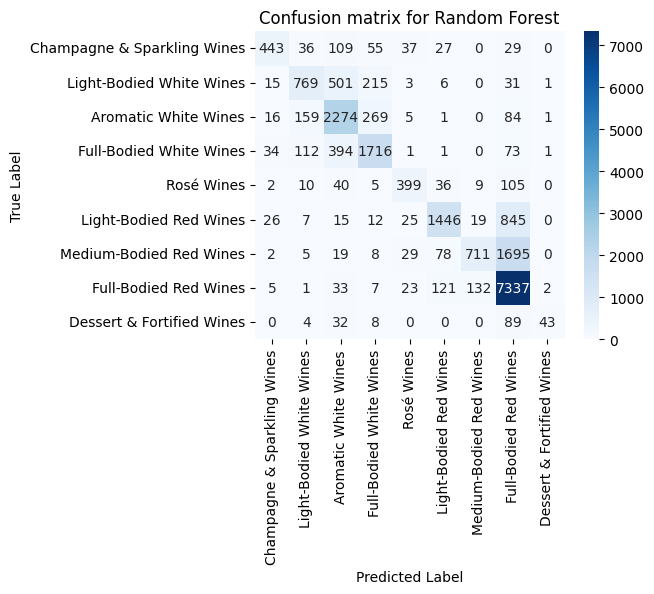

In [109]:
print_report(y_train_val, y_pred_rf, "Random Forest")

Grouped classification report for Random Forest:

               precision    recall  f1-score   support

      desert       0.90      0.24      0.38       176
         red       0.96      0.98      0.97     12603
        rosé       0.76      0.66      0.71       606
       white       0.97      0.96      0.96      7418

    accuracy                           0.96     20803
   macro avg       0.90      0.71      0.76     20803
weighted avg       0.96      0.96      0.96     20803



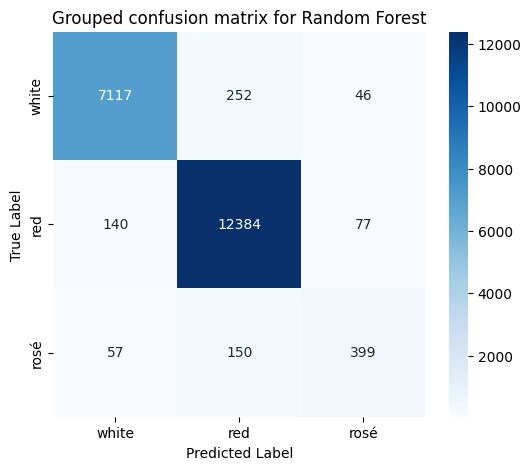

In [110]:
print_grouped_report(y_train_val, y_pred_rf, "Random Forest")

## XGBoost

XGBoost (eXtreme Gradient Boosting) koristi tehniku pojačavanja, gde se modeli grade sekvencijalno, pri čemu svako novo stablo ispravlja greške prethodnih. Ovaj pristup omogućava modelu da nauči iz grešaka i postane sve precizniji kroz iteracije.  

Kako bismo pronašli optimalne hiperparametre maksimalne dubine i broja stabala ansambla, koristimo paket `optuna`. Posebno ćemo ispitati optimalnu dubinu za fiksiran broj stabala, tražeći model koji ima minimalni težinski prosek f1 skora.

In [111]:
label_encoder = LabelEncoder()

y_train_encoded = label_encoder.fit_transform(y_train_train)
y_val_encoded = label_encoder.transform(y_train_val)  

def objective(trial):
    max_depth = trial.suggest_int('max_depth', 10, 200)
    #n_estimators = trial.suggest_int('n_estimators', 100, 500)
    n_estimators = 100
    print(f"{trial.number = } : {max_depth = }, {n_estimators = }")

    model = xgboost.XGBClassifier(
        objective='multi:softmax', 
        n_estimators=n_estimators,  
        max_depth=max_depth,  
        random_state=42, 
        tree_method="hist",
        device="cuda"
    )

    model.fit(X_train_train, y_train_encoded)
    y_pred_val = model.predict(X_train_val)
    w_f1_score = f1_score(y_val_encoded, y_pred_val, average='weighted')
    print(f"{w_f1_score = :.4f}\n\n")

    return w_f1_score

# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=10)
# with open('optuna_study.pkl', 'wb') as f:
#     pickle.dump(study, f)
with open('optuna_study.pkl', 'rb') as f:
    study = pickle.load(f)

print("Best hyperparameters found: ", study.best_params)
print("Best f1 score: ", study.best_value)

Best hyperparameters found:  {'max_depth': 72}
Best f1 score:  0.7512255491203347


In [114]:
import xgboost as xgb
from sklearn.metrics import f1_score

dtrain = xgb.DMatrix(X_train_train, label=y_train_encoded)
dval = xgb.DMatrix(X_train_val, label=y_val_encoded)

params = {
    'objective': 'multi:softmax',
    'num_class': len(set(y_train_encoded)),  
    'max_depth': 72,
    'tree_method': 'hist',
    'random_state': 42,
    'device': 'cuda',  
}

model_final = xgb.train(params, dtrain, num_boost_round=200)
with open("xgb_model.pkl", "wb") as f:
    pickle.dump(model_final, f)

# with open("xgb_model.pkl", "rb") as f:
#     model_final_loaded = pickle.load(f)

y_pred_val = model_final.predict(dval)
w_f1_score = f1_score(y_val_encoded, y_pred_val, average='weighted')
print(f"{w_f1_score = :.4f}")

KeyboardInterrupt: 

Classification report for XGBoost:

                              precision    recall  f1-score   support

Champagne & Sparkling Wines       0.83      0.70      0.76       736
   Light-Bodied White Wines       0.67      0.59      0.63      1541
       Aromatic White Wines       0.73      0.80      0.77      2809
    Full-Bodied White Wines       0.76      0.77      0.76      2332
                 Rosé Wines       0.76      0.71      0.73       606
     Light-Bodied Red Wines       0.81      0.72      0.76      2395
    Medium-Bodied Red Wines       0.70      0.44      0.54      2547
      Full-Bodied Red Wines       0.78      0.91      0.84      7661
  Dessert & Fortified Wines       0.70      0.34      0.45       176

                   accuracy                           0.76     20803
                  macro avg       0.75      0.67      0.69     20803
               weighted avg       0.76      0.76      0.75     20803



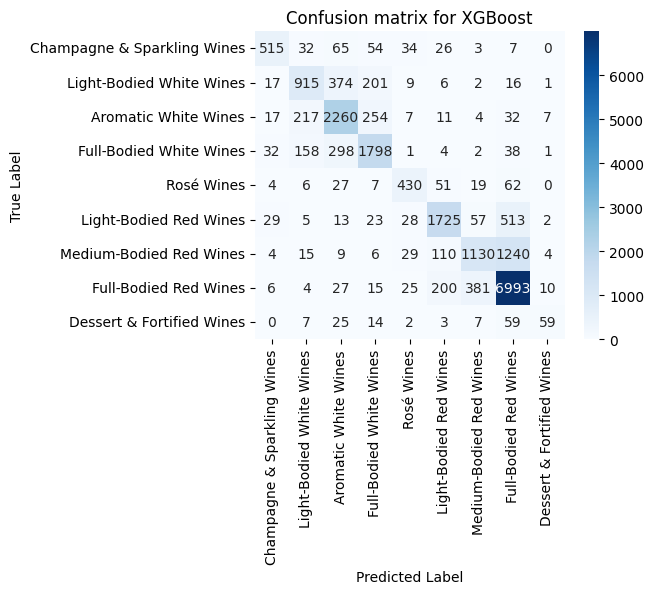

Grouped classification report for XGBoost:

               precision    recall  f1-score   support

      desert       0.70      0.34      0.45       176
         red       0.97      0.98      0.98     12603
        rosé       0.76      0.71      0.73       606
       white       0.97      0.97      0.97      7418

    accuracy                           0.96     20803
   macro avg       0.85      0.75      0.78     20803
weighted avg       0.96      0.96      0.96     20803



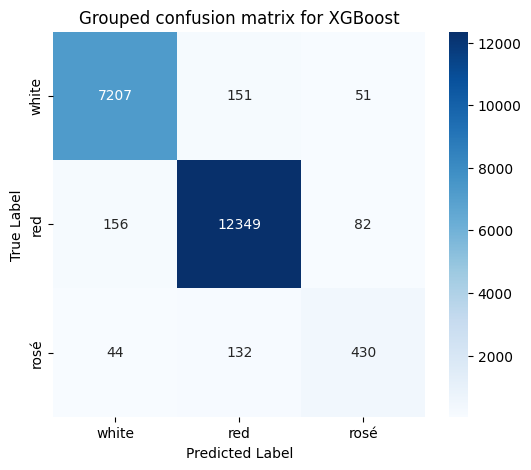

In [50]:
print_report(y_train_val, label_encoder.inverse_transform(y_pred_val.astype(int)), "XGBoost")
print_grouped_report(y_train_val, label_encoder.inverse_transform(y_pred_val.astype(int)), "XGBoost")

### Vektorizacija klasa

Pomenuli smo problem nejednakih gresaka i da naš model to ne zna da razlikuje. Jedan način da to uradimo je tako sto cemo svakoj klasi dodeliti jedan vektor. To možemo uraditi ručno na osnovu domenskog znanja:

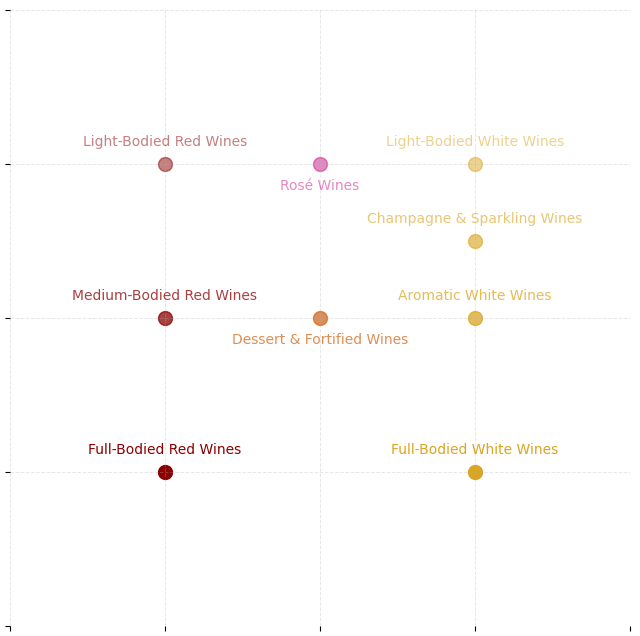

In [75]:
wine_positions ={
    "Champagne & Sparkling Wines": (1, 0.5, "white"),
    "Light-Bodied White Wines": (1, 1, "white"),
    "Aromatic White Wines": (1, 0, "white"),
    "Full-Bodied White Wines": (1, -1, "white"),
    "Rosé Wines": (0, 1, "rosé"),
    "Light-Bodied Red Wines": (-1, 1, "red"),
    "Medium-Bodied Red Wines": (-1, 0, "red"),
    "Full-Bodied Red Wines": (-1, -1, "red"),
    "Dessert & Fortified Wines": (0, 0, "desert")
}

wine_colors={
    "white": "goldenrod",
    "red": "darkred",
    "rosé": "mediumvioletred",
    "desert": "chocolate"
}


plt.figure(figsize=(8, 8))

for label, (x, y, wine_type) in wine_positions.items():
    alpha = 0.5 + (-y + 1) / 4
    color = wine_colors[wine_type]  
    
    if wine_type == "rosé" or wine_type == "desert":
        plt.text(x, y - 0.1, label, fontsize=10, ha='center', va='top', color=color, alpha=alpha)
    else:
        plt.text(x, y + 0.1, label, fontsize=10, ha='center', va='bottom', color=color, alpha=alpha)

    plt.scatter(x, y, s=100, color=color, alpha=alpha)

plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.3)
plt.xticks(range(-2, 3))
plt.yticks(range(-2, 3))
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.gca().set_xticklabels([])
plt.gca().set_yticklabels([])
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)

plt.show()


Drugi način bio bi korišćenjem vektora reprezentacije teksta (*word embeddings*) koji su unapred trenirani tako da slični tekstovi imaju slične vektore. U primeru koristimo `text-embedding-3-small` za preslikavanje tekstova u vektore dimenzije 1536, što je isti red veličine kao vektori dobijeni TD-IDF vektorizacijom. 

Prednost korišćenja unapred treniranih modela za vektorizaciju je prenos znanja o značenju reči, dobijeno na velikom korpusu na kojem je treniran. Sa druge strane, kako je takav model predviđen da vektorizuje bilo koji tekst, a svi tekstovi koji se odnose na senzorne karakteristike vina više liče jedan na drugi nego na većinu drugih tekstova u korpusu, oni će zajedno okupirati mali deo prostora tekstova. 

Sa grafika vidimo da se vektori reprezentacija belih i crnih vina više razlikuju, nego vrste crnih vina međusobno, što je u skladu sa pređašnjim modelima.

In [197]:
from sklearn.manifold import TSNE
import openai
import os

openai.api_key = os.getenv("OPENAI_API_KEY")
client = openai.OpenAI()

def get_embedding(text, model="text-embedding-3-small"):
    text = text.replace("\n", " ")
    return client.embeddings.create(input = [text], model=model).data[0].embedding

X_train_subset = X_train[:1000]
y_train_subset = y_train[:1000]

# embeddings = [get_embedding(text) for text in X_train_subset]
# with open("text_embeddings.pck", "wb") as file:
#     pickle.dump(embeddings, file)
    
with open("text_embeddings.pck", "rb") as file:
    embeddings = pickle.load(file)

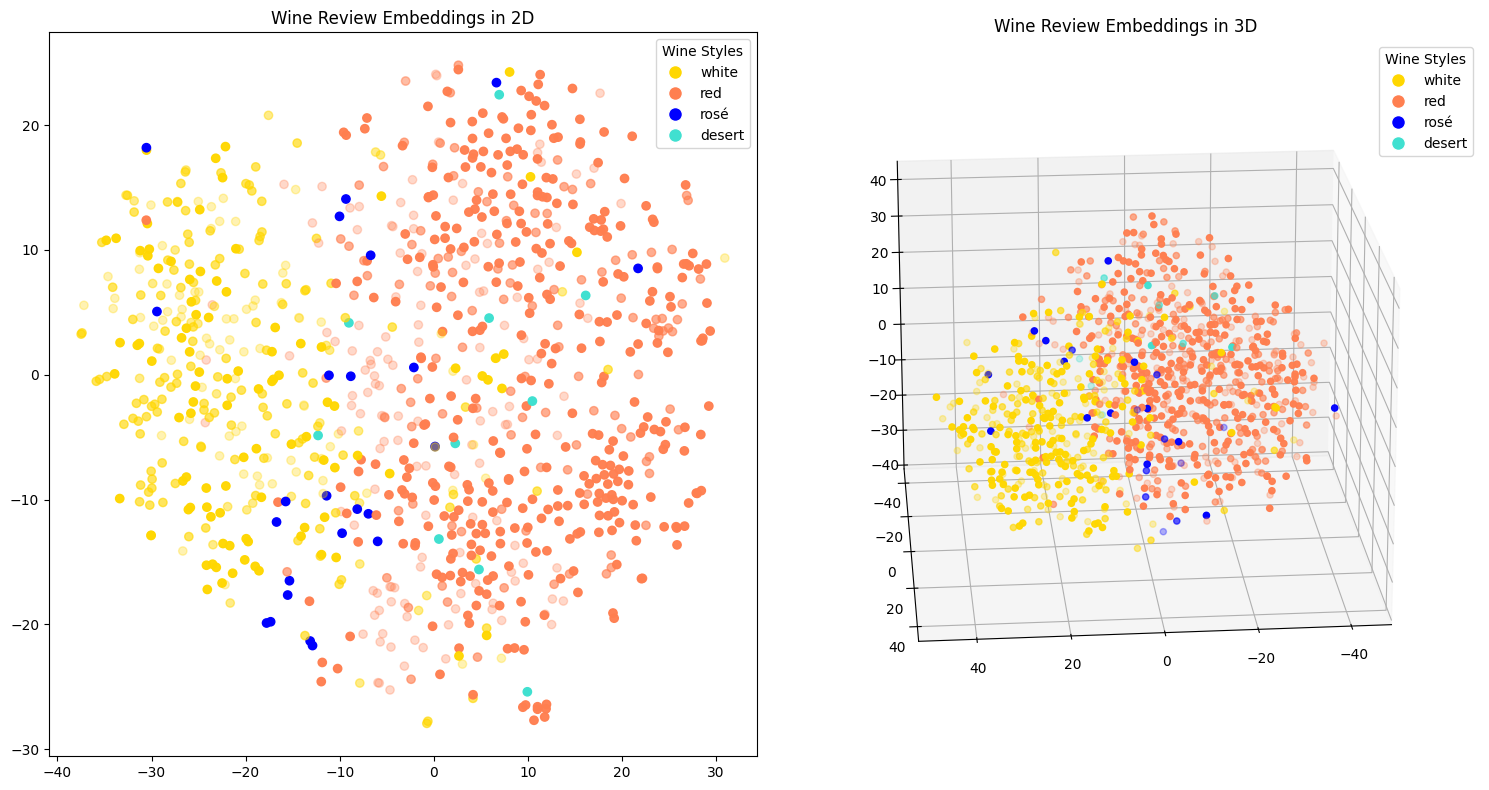

In [325]:
from sklearn.manifold import TSNE

embeddings = np.array(embeddings)

tsne_2d = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne_2d.fit_transform(embeddings)

tsne_3d = TSNE(n_components=3, random_state=42)
embeddings_3d = tsne_3d.fit_transform(embeddings)

wine_styles = [wine_positions[category][2] for category in y_train_subset]
wine_alpha = [0.3 + (-wine_positions[category][1] + 1) / 3 if wine_positions[category][2] in ['white', 'red'] else 1 for category in y_train_subset]
plot_colors = {'white': 'gold', 'red': 'coral', 'rosé': 'blue', 'desert': 'turquoise'}
colors = [plot_colors[style] for style in wine_styles]

fig = plt.figure(figsize=(15, 8))

ax1 = fig.add_subplot(121)
scatter_2d = ax1.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=colors, alpha=wine_alpha)
ax1.set_title('Wine Review Embeddings in 2D')

ax2 = fig.add_subplot(122, projection='3d')
scatter_3d = ax2.scatter(embeddings_3d[:, 0], embeddings_3d[:, 1], embeddings_3d[:, 2], c=colors, alpha=wine_alpha)
ax2.set_title('Wine Review Embeddings in 3D')
ax2.view_init(elev=20, azim=85)  

unique_styles = list(plot_colors.keys())
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=plot_colors[style], markersize=10) for style in unique_styles]

ax1.legend(handles=handles, labels=unique_styles, title='Wine Styles', loc='upper right')
ax2.legend(handles=handles, labels=unique_styles, title='Wine Styles', loc='upper right')

plt.tight_layout()
plt.show()


In [329]:
X_train_train_emb,X_train_val_emb, y_train_train_emb, y_train_val_emb = train_test_split(embeddings, y_train_subset, test_size=0.2, random_state=42, stratify=y_train_subset)

Classification report for Closest embedding:

                              precision    recall  f1-score   support

Champagne & Sparkling Wines       0.20      0.17      0.18         6
   Light-Bodied White Wines       0.38      0.50      0.43        16
       Aromatic White Wines       0.65      0.41      0.50        27
    Full-Bodied White Wines       0.50      0.58      0.54        19
                 Rosé Wines       0.44      0.80      0.57         5
     Light-Bodied Red Wines       0.59      0.57      0.58        28
    Medium-Bodied Red Wines       0.38      0.43      0.41        23
      Full-Bodied Red Wines       0.75      0.69      0.72        74
  Dessert & Fortified Wines       0.20      0.50      0.29         2

                   accuracy                           0.56       200
                  macro avg       0.46      0.52      0.47       200
               weighted avg       0.59      0.56      0.57       200



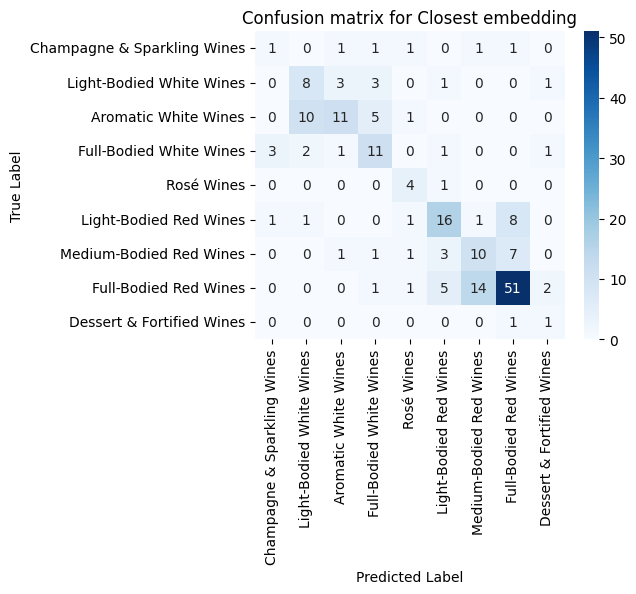

Grouped classification report for Closest embedding:

               precision    recall  f1-score   support

      desert       0.20      0.50      0.29         2
         red       0.95      0.92      0.93       125
        rosé       0.44      0.80      0.57         5
       white       0.92      0.88      0.90        68

    accuracy                           0.90       200
   macro avg       0.63      0.78      0.67       200
weighted avg       0.92      0.90      0.91       200



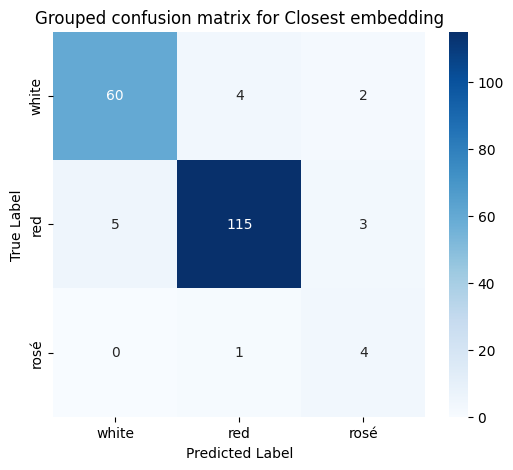

In [330]:
from sklearn.metrics.pairwise import cosine_similarity

class_embeddings = {}
for label in set(y_train_subset):
    class_embeddings[label] = np.mean(X_train_train_emb[y_train_train_emb == label], axis=0)

y_pred_emb = []
for embedding in X_train_val_emb:
    similarities = [cosine_similarity(embedding.reshape(1, -1), class_embeddings[label].reshape(1, -1))[0][0] for label in class_embeddings]
    closest_label = list(class_embeddings.keys())[np.argmax(similarities)]
    y_pred_emb.append(closest_label)
    
print_report(y_train_val_emb, y_pred_emb, "Closest embedding")
print_grouped_report(y_train_val_emb, y_pred_emb, "Closest embedding")